# Cell/Nuclei Neighborhood Distances and Characteristics

The neighborhood of a cell is defined by the cells that are within a certain distance from the cell. These neighborhoods show spatial patterns related to cell-cell interactions. Often, we are interested in some reduced summaries (mean/median etc) of the neighborhoods (neighborhood characteristics) that can tell us whether there exist some non-random patterns in the spatial distribution of the cell-cell interactions.

In this notebook, we will be looking at computing neighborhood characters and also take a look at computing neighborhood distances of the cells. 

## The Data

We'll be taking a look at a small tile of cells at the tumor-stroma interface i.e. at the border where the tumor meets stroma. The tumor in the data also contains a couple small blood vessels that introduce tumor-stroma interface within the tumor. 

<Axes: >

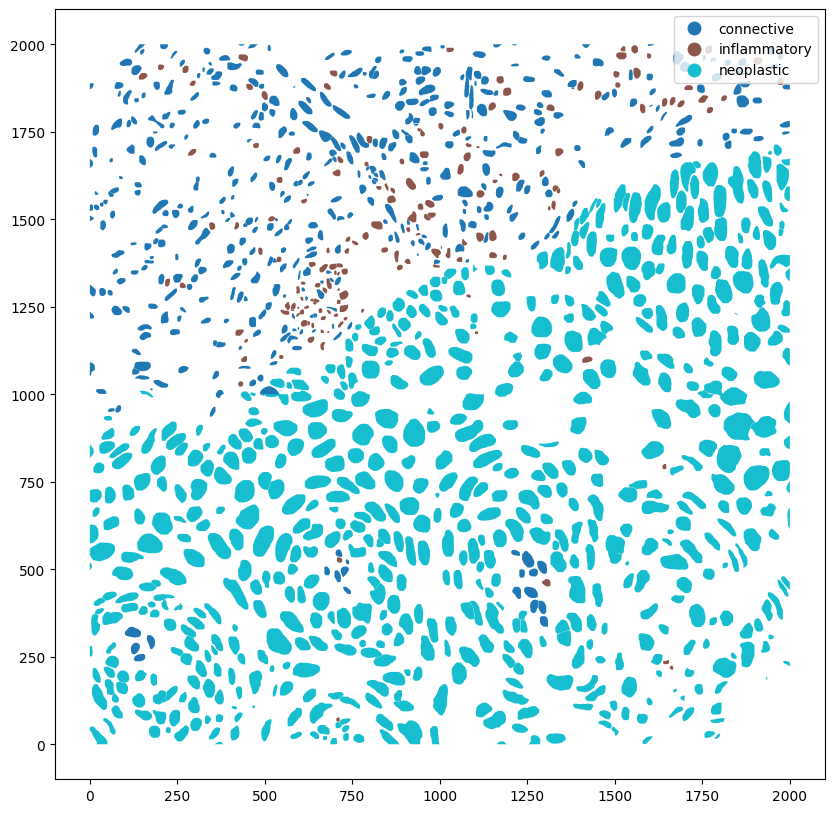

In [1]:
from cellseg_gsontools.data import tumor_stroma_intreface_cells

tsc = tumor_stroma_intreface_cells()
tsc.plot(column="class_name", figsize=(10,10), legend=True)

## Spatial Weights

To get the neighborhoods of the cells, we will first fit a connectivity graph (called spatial weights in geospatial analysis jargon) to the `GeoDataFrame`. `cellseg_gsontools` provides a `fit_graph` function which can be used to do that. The actual fitting is done with the `libpysal` package and the `fit_graph`-function is basically a wrapper around different graph fitting methods. The allowed spatial weights are:

- `knn`: k-nearest neighbors
- `delaunay` - Delaunay triangulation
- `distband` - Distance band i.e. a distance thresholded knn graph
- `relative_nhood` - Relative neighborhood graph

We will be using the `delaunay` method in this example, however, note that for large data the `delaunay` method can get quite slow and for example the `distband` method is a lot faster. Here, we will set a distance threshold for the neighbors to be within 50 microns of the cell centroid. The distance unit in the example data is in pixels so 50 microns in pixels of 20x magnified segmentation mask is around 50*2 = 100 pixels.

In [2]:
from cellseg_gsontools.graphs import fit_graph
from cellseg_gsontools.utils import set_uid

# To fit the delaunay graph, we need to set a unique id for each cell first
tsc = set_uid(tsc, id_col="uid")
w = fit_graph(tsc, type="delaunay", thresh=100, id_col="uid")
w

<Axes: >

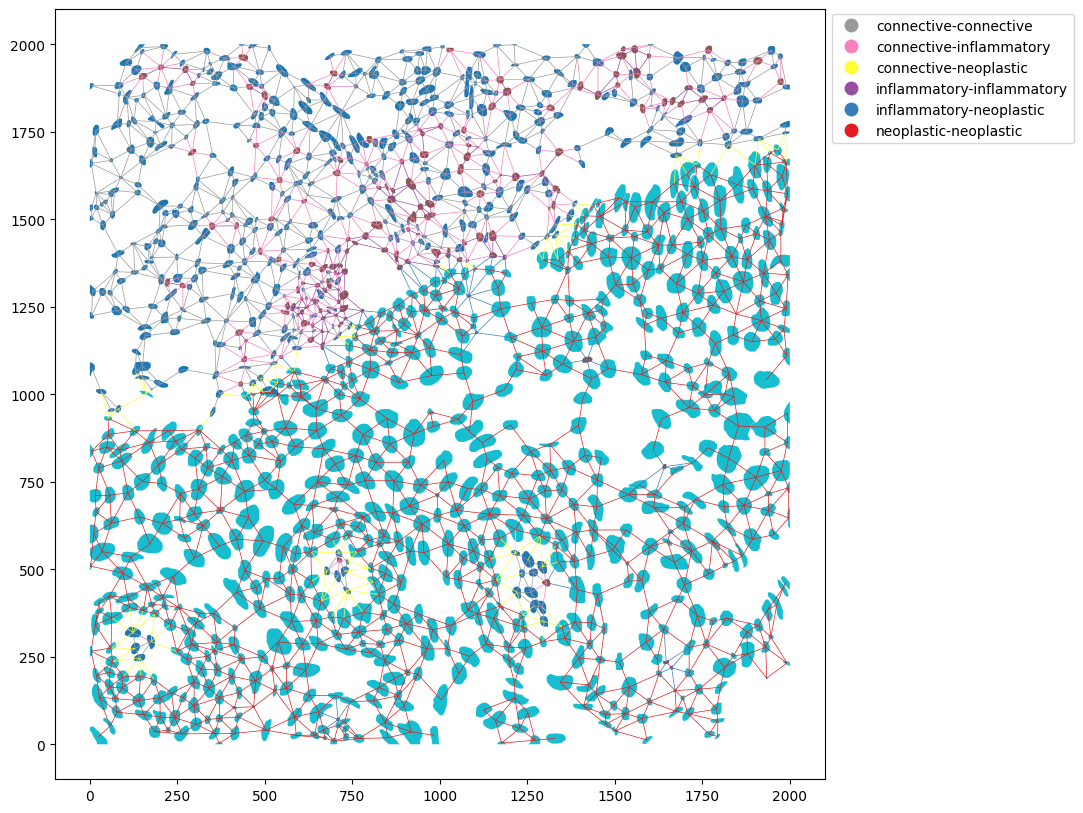

In [3]:
# let's convert the graph to a dataframe and plot it
from cellseg_gsontools.links import weights2gdf

wdf = weights2gdf(tsc, w)
ax = tsc.plot(column="class_name", figsize=(10,10), legend=True)
wdf.plot(
    ax=ax,
    linewidth=0.5,
    column="class_name",
    cmap="Set1_r",
    legend=True,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (1.0, 0.91)
    }
)

## Neighborhood Characters

To compute neighborhood character, we first need to compute some real valued columns to the `GeoDataFrame`. These columns will be used to compute the neighborhood characters. The `cellseg_gsontools` package provides a `local_characters` function for this purpose. But first, let's use the `shape_metric`-function to compute some morphological features.

### Computing Morphological Features

In [4]:
from cellseg_gsontools.geometry import shape_metric

# let's first compute a couple shape metrics
metrics = [
    "area",
    "eccentricity",
    "sphericity",
    "fractal_dimension"
]

tsc = shape_metric(
    tsc,
    metrics=metrics,
    parallel=True,
)

tsc.head(4)

type                                           geometry  class_name  \
uid                                                                           
0    Feature  POLYGON ((169.012 42.997, 170.011 45.994, 174....  neoplastic   
1    Feature  POLYGON ((183.996 97.988, 192.079 94.544, 194....  neoplastic   
2    Feature  POLYGON ((130.006 97.989, 133.003 98.988, 136....  neoplastic   
3    Feature  POLYGON ((63.174 103.174, 70.007 109.990, 72.0...  neoplastic   

     uid         area  eccentricity  sphericity  fractal_dimension  
uid                                                                 
0      0   943.538625      0.405200    0.794631           0.405200  
1      1  1075.707286      0.435784    0.553602           0.435784  
2      2  1044.121328      0.822321    0.496494           0.822321  
3      3   833.673039      0.795212    0.556992           0.795212

<Axes: >

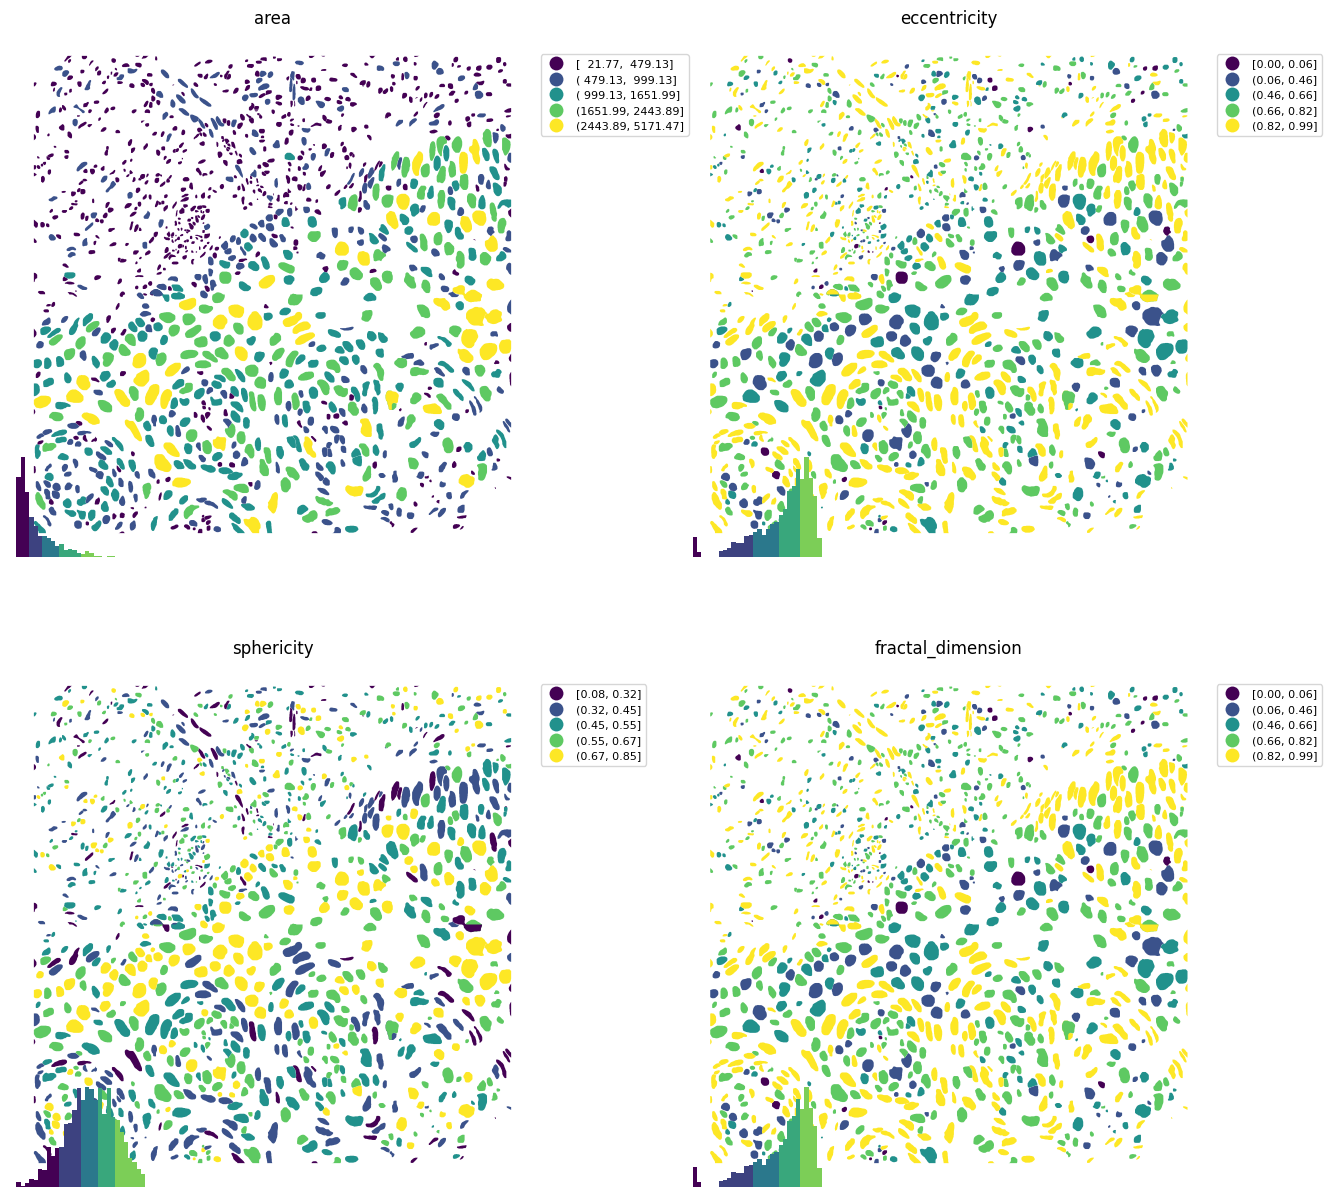

In [5]:
import mapclassify
import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as palet
from legendgram import legendgram

# helper function to replace legend items
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


# Helper function to plot cells with a feature value highlighted
def plot_cells(f, ax, cells: gpd.GeoDataFrame, col: str):
    # bin the values with the Fisher-Jenks method
    bins = mapclassify.FisherJenks(cells[col], k=5)
    cells["bin_vals"] = bins.yb

    ax = cells.plot(
        ax=ax,
        column="bin_vals",
        cmap="viridis",
        categorical=True,
        legend=True,
        legend_kwds={
            "fontsize": 8,
            "loc": "center left",
            "bbox_to_anchor": (1.0, 0.88),
        },
    )

    bin_legends = bins.get_legend_classes()
    mapping = dict([(i, s) for i, s in enumerate(bin_legends)])
    replace_legend_items(ax.get_legend(), mapping)
    ax.set_axis_off()
    ax.set_title(col)
    ax = legendgram(
        f,
        ax,
        cells[col],
        bins=30,
        breaks=bins.bins,
        pal=palet.matplotlib.Viridis_5,
        loc="lower left",
    )
    ax.set_axis_off()

    return ax

fig, ax = plt.subplots(2, 2, figsize=(16, 15))
ax = ax.flatten()
plot_cells(fig, ax[0], tsc, "area")
plot_cells(fig, ax[1], tsc, "eccentricity")
plot_cells(fig, ax[2], tsc, "sphericity")
plot_cells(fig, ax[3], tsc, "fractal_dimension")


### Computing Neighborhood Characters

Let's now compute the neighborhood characteristics. We will reduce the neighborhood feature values with mean and std.

In [6]:
from cellseg_gsontools.character import local_character

tsc = local_character(
    tsc,
    w,
    val_col=("eccentricity", "area"),
    id_col="uid",
    reductions=("mean", "std"),
    parallel=True,
)

tsc.head(4)

type                                           geometry  class_name  \
uid                                                                           
0    Feature  POLYGON ((169.012 42.997, 170.011 45.994, 174....  neoplastic   
1    Feature  POLYGON ((183.996 97.988, 192.079 94.544, 194....  neoplastic   
2    Feature  POLYGON ((130.006 97.989, 133.003 98.988, 136....  neoplastic   
3    Feature  POLYGON ((63.174 103.174, 70.007 109.990, 72.0...  neoplastic   

     uid         area  eccentricity  sphericity  fractal_dimension  bin_vals  \
uid                                                                            
0      0   943.538625      0.405200    0.794631           0.405200         1   
1      1  1075.707286      0.435784    0.553602           0.435784         1   
2      2  1044.121328      0.822321    0.496494           0.822321         4   
3      3   833.673039      0.795212    0.556992           0.795212         3   

     eccentricity_nhood_mean  eccentricity_nhood_std  area_nhood_mean  \
uid                                                                     
0                   0.609431                0.179600       888.701111   
1                   0.534537                0.205870       933.802622   
2                   0.491460                0.236136      1035.535479   
3                   0.724457                0.233204      1004.582806   

     area_nhood_std  
uid                  
0        350.895749  
1        335.974217  
2        116.271775  
3        488.473078

<Axes: title={'center': 'eccentricity_nhood_std'}>

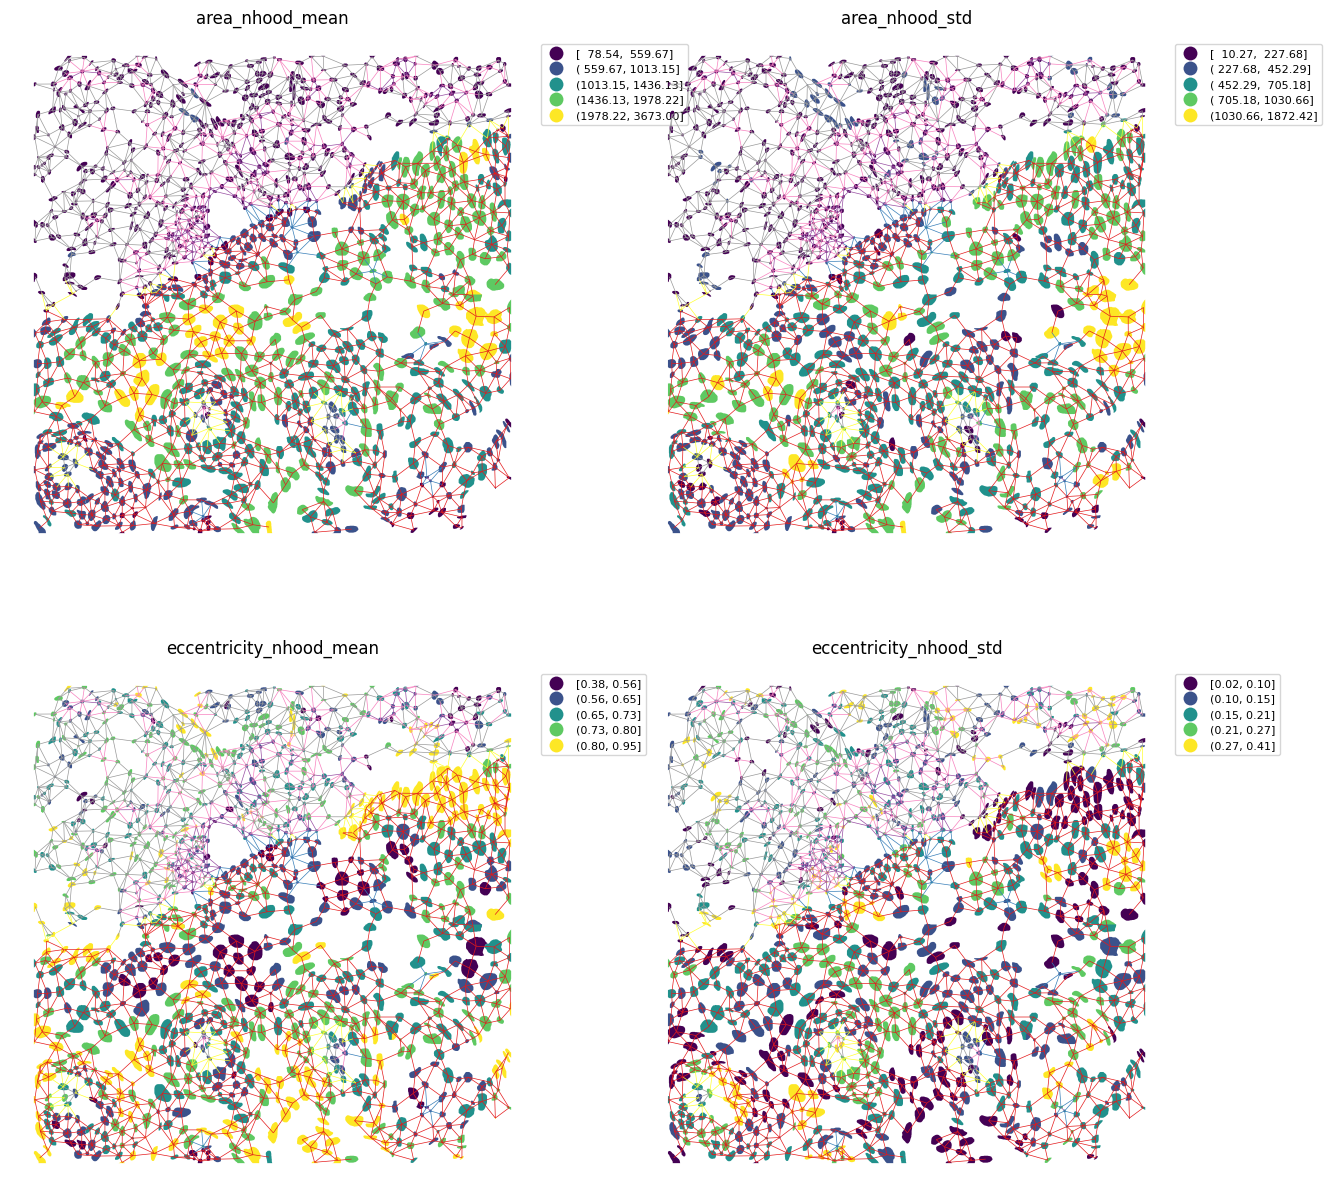

In [7]:
# Aand some plots
def plot_character(ax, cells, col, plot_weights=True, cmap="viridis"):
    # bin the values with the FisherJenks method for visualization
    bins = mapclassify.FisherJenks(cells[col], k=5)
    cells["bin_vals"] = bins.yb
    ax = cells.plot(
        ax=ax,
        column="bin_vals",
        categorical=True,
        cmap=cmap,
        legend=True,
        legend_kwds={
            "fontsize": 8,
            "loc": "center left",
            "bbox_to_anchor": (1.0, 0.90),
        },
    )

    bin_legends = bins.get_legend_classes()
    mapping = dict([(i, s) for i, s in enumerate(bin_legends)])
    replace_legend_items(ax.get_legend(), mapping)
    ax.set_title(col)
    
    if plot_weights:
        ax = wdf.plot(
            ax=ax,
            linewidth=0.5,
            column="class_name",
            cmap="Set1_r",
        )
    ax.set_axis_off()

    return ax


fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()

plot_character(ax[0], tsc, "area_nhood_mean", plot_weights=True)
plot_character(ax[1], tsc, "area_nhood_std", plot_weights=True)
plot_character(ax[2], tsc, "eccentricity_nhood_mean", plot_weights=True)
plot_character(ax[3], tsc, "eccentricity_nhood_std", plot_weights=True)

Based on the plot, the high eccentricity neighborhoods tend to cluster around the blood vessels and the tumor-stroma interface. The high area neighborhoods are more evenly distributed, although, they reside in the tumor tissue since tumor cells tend to be larger than stromal cells. The cells with high area or eccentricity standard deviation seem to be scattered quite randomly in places where there are abundance of differently shaped cells, that is in the tumor area. Thus, we can conclude that the tumor cells tend to have more variance in their shapes than the stromal cells from this plot.

## Neighborhood Distances

Let's now compute some neighborhood distances. The mean distances of the neighborhoods can be computed with the `local_distances`-function. The mean neighborhood distances highlight the cells whose neighbors are either densely packed or further apart. It is a nice way of highlighting dense clusters of cells in a segmentation map. Here, we will invert the color map of the plot so that the densely packed cells are highlighted instead of the cells whose neighbors are far apart.

In [8]:
from cellseg_gsontools.character import local_distances

tsc = local_distances(
    tsc,
    w,
    id_col="uid",
    reductions=("mean", "std"),
    invert=False,
    parallel=True,
)

tsc[["geometry", "class_name", "nhood_dists_mean", "nhood_dists_std"]].head(4)

geometry  class_name  \
uid                                                                  
0    POLYGON ((169.012 42.997, 170.011 45.994, 174....  neoplastic   
1    POLYGON ((183.996 97.988, 192.079 94.544, 194....  neoplastic   
2    POLYGON ((130.006 97.989, 133.003 98.988, 136....  neoplastic   
3    POLYGON ((63.174 103.174, 70.007 109.990, 72.0...  neoplastic   

     nhood_dists_mean  nhood_dists_std  
uid                                     
0             43.8952        25.682826  
1             38.8290        17.875030  
2             48.5410        24.549408  
3             49.6515        26.040834

<Axes: title={'center': 'nhood_dists_std'}>

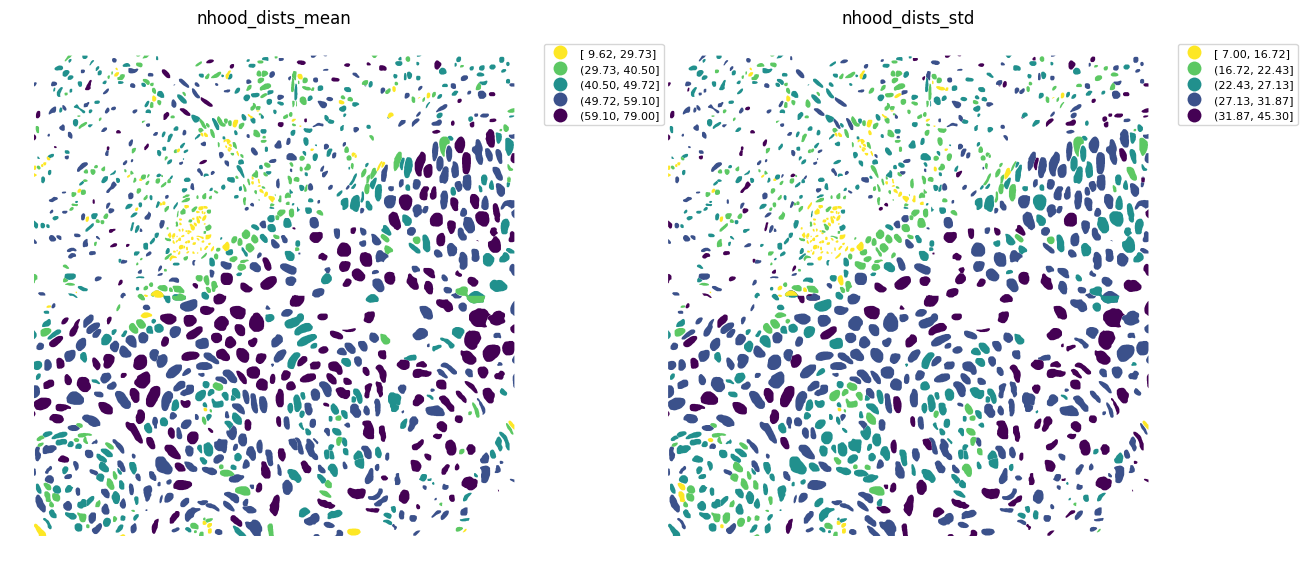

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax = ax.flatten()

# let's not plot the weights to see the effect of the distance better
plot_character(ax[0], tsc, "nhood_dists_mean", plot_weights=False, cmap="viridis_r")
plot_character(ax[1], tsc, "nhood_dists_std", plot_weights=False, cmap="viridis_r")

We can see that by computing the neighborhood distances, we can easily highlight the densely packed cells. In this example, the densely packed cells are lymphocytes residing close to the tumor-stroma interface. These kind of immune clusters are of interest when researching the immune response of the tumor.